In [ ]:
# Importing packages
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import nltk
import pandas as pd
from collections import Counter
from tqdm.auto import tqdm
import re, time, json,pickle
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk import ngrams
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
path = "drive/MyDrive/NLP/"



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# load saved corpus from Google Drive
%%time
path = r"drive/MyDrive/NLP/corpus_final.txt"
st = ""
with open(path, 'r') as f:
  st = f.readlines()

CPU times: user 968 ms, sys: 677 ms, total: 1.65 s
Wall time: 8.78 s


In [ ]:
#Text preprocessing

stemmer = WordNetLemmatizer()

def preprocess_text(document):
        stop_words = set(stopwords.words('english'))
        en_stop = list(stop_words)
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(document))

        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)

        # Converting to Lowercase
        document = document.lower()
        tokens = document.split()
        tokens = [stemmer.lemmatize(word) for word in tokens]
        tokens = [word for word in tokens if word not in en_stop]
        tokens = [word for word in tokens if len(word) > 3]

        preprocessed_text = ' '.join(tokens)

        return preprocessed_text


In [ ]:
pre_corp = []
for t in tqdm(range(len(st))):
  txt = preprocess_text(str(st[t]))
  pre_corp.append(txt)

In [ ]:
with open("drive/MyDrive/NLP/preprocessed_covid.txt", 'w') as output:
    for row in pre_corp:
        output.write(str(row) + '\n')

In [ ]:
%%time
path = "drive/MyDrive/NLP/"
file_name = "preprocessed_covid.txt"
with open(path + file_name, 'r') as c:
  pre_corp = c.readlines()


CPU times: user 488 ms, sys: 383 ms, total: 870 ms
Wall time: 4.08 s


In [ ]:
all_corp = []
vocab_dict = Counter()
START_TOKEN = "<Pad_strt> "
END_TOKEN = " <Pad_end>"
for t in tqdm(range(len(st))):
  txt = preprocess_text(str(st[t]))
  sen = sent_tokenize(txt)
  pad_text = [START_TOKEN + t.lower() + END_TOKEN for t in sen]
  pd = " ".join(pad_text)
  vocab_dict.update(pd.split())


In [ ]:
with open("/content/drive/MyDrive/NLP/vocab_full.json", "w") as outfile:
    json.dump(vocab_dict, outfile)

In [ ]:
f = open("/content/drive/MyDrive/NLP/vocab_full.json","r")
vocab_freq = json.load(f)

In [ ]:
def my_filtering_function(pair):
    key, value = pair
    if value >= 150:
        return True  # keep pair in the filtered dictionary
    else:
        return False  # filter pair out of the dictionary
vocab_filter = dict(filter(my_filtering_function, vocab_freq.items()))
print("Vocab Length: ")
len(vocab_filter.keys())


Vocab Length: 


15213

In [ ]:
ind_voc = dict(enumerate(list(vocab_filter.keys())))
vocab_idx = {v: k for k, v in ind_voc.items()}
word_lst = list(vocab_filter.keys())
v = len(vocab_filter.keys())
hal_l2r = np.zeros((v,v))
hal_r2l = np.zeros((v,v))
ramp = [0, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
for s in tqdm(pre_corp):
  wrd = s.split()
  wrds = [w.lower() for w in wrd]
  n_grams = ngrams(wrds, 11, pad_right = True, pad_left= True)
  for w in wrds:
    if w in vocab_filter.keys():
      for index, grams in enumerate(n_grams):
        reversed_grams = grams[::-1]
        if not None in grams:
          #  Left to right
          for idx, gram in enumerate(grams):
            try:
              hal_l2r[vocab_idx[grams[0]],vocab_idx[grams[idx]]] += ramp[idx]
            except:
              pass
          # right to left
          for idx, gram in enumerate(reversed_grams):
            try:
              hal_r2l[vocab_idx[reversed_grams[0]],vocab_idx[reversed_grams[idx]]] += ramp[idx]
            except:
              pass




  0%|          | 0/39999 [00:00<?, ?it/s]

In [ ]:
import pickle
with open(path + "L2R", "wb") as out:   #Pickling
  pickle.dump(hal_l2r, out)
with open(path + "R2L", "wb") as out2:   #Pickling
  pickle.dump(hal_r2l, out2)

**Checkpoint 1 : In case of ram crash run from here.**

In [ ]:
path = "drive/MyDrive/NLP/"
with open(path + "L2R", 'rb') as pickle_file:
    hal_l2r = pickle.load(pickle_file)
with open(path + "R2L", 'rb') as pickled_file:
    hal_r2l = pickle.load(pickled_file)
assert(hal_l2r.shape == hal_r2l.shape)

In [ ]:
# Dealing with Null rows (all values in the row are zero) and normalising the matrix
hal_l2r = hal_l2r[~np.all(hal_l2r == 0, axis=1)]
la = np.linalg
hal_l2r = [row/la.norm(row) for row in hal_l2r]
hal_r2l = hal_r2l[~np.all(hal_r2l == 0, axis=1)]
la = np.linalg
hal_r2l = [row/la.norm(row) for row in hal_r2l]

In [ ]:
halmat = np.concatenate((hal_l2r, hal_r2l), axis = 1)
with open(path + "halmat", 'wb') as pickle_file:
    pickle.dump(halmat,pickle_file)

In [ ]:
with open(path + "halmat", 'rb') as pickle_file:
    halmat = pickle.load(pickle_file)

In [ ]:
#using principal component analysis to get the word vectors
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
word_vecs = pca.fit_transform(halmat)
word_vecs.shape
with open(path + "word_vec", 'wb') as pickled:
    pickle.dump(word_vecs,pickled)

**Checkpoint 2: Work with saved data**

In [ ]:
with open(path + "word_vec", 'rb') as pickled:
    word_vecs = pickle.load(pickled)

In [ ]:
# Defining a minkowski metric to compute similarity between two word vectors
import math
def minkowski(v1, v2):
  assert len(v1) == len(v2)
  s = 0.0
  for i in range(len(v1)):
    s+=(float(abs(v1[i] - v2[i])**2))
  return math.sqrt(s)


In [ ]:
# dictionary slicing
from itertools import islice
def take(iterable, n = 50):
    return dict(islice(iterable, n))

In [ ]:
allwrds = list(vocab_filter.keys())[:-2]
ind_wrd = dict(enumerate(allwrds))
word_similarity = {}
word_dict = dict(zip(allwrds,word_vecs))
for i in tqdm(word_dict.keys()):
  metric = []
  for j in word_dict.keys():
    metric.append(minkowski(word_dict[i],word_dict[j]))
  val = dict(sorted(dict(enumerate(metric)).items(), key = lambda x: x[1], reverse = True)).items()
  word_similarity[i] = take(val)


  0%|          | 0/15211 [00:00<?, ?it/s]

In [ ]:
word_similarity['hospital']

{9265: 1.2637435722956194,
 2075: 1.2540693595757662,
 9255: 1.2491870258557476,
 9278: 1.2478923681638132,
 2104: 1.2478660943536988,
 9270: 1.247611741530383,
 9245: 1.247608289215906,
 2090: 1.2466638548351314,
 11178: 1.2457573995712745,
 9256: 1.2452812532562527,
 2080: 1.244683197789298,
 9280: 1.2445777817233181,
 13239: 1.2433751920895066,
 9284: 1.2431388771684038,
 2085: 1.243093831019366,
 9263: 1.2426424953468174,
 9305: 1.2418617038627378,
 11151: 1.2415032200942875,
 13350: 1.241038678120617,
 13199: 1.2407603059110455,
 11171: 1.240466992658206,
 2096: 1.2401525972124456,
 2103: 1.239128144583515,
 9272: 1.2384730033125604,
 13202: 1.2382366243035083,
 2081: 1.2377415646084509,
 11147: 1.237476383237035,
 9262: 1.2366824424727927,
 2095: 1.236068987217852,
 11206: 1.2360536159431446,
 9246: 1.2358116243821882,
 11154: 1.2349769448437766,
 13228: 1.2343798340429402,
 9264: 1.234336804057811,
 9292: 1.2333324004683672,
 11172: 1.2331717310050316,
 11153: 1.233119385171078,

#Word Vector Plots

In [ ]:
#plotting function for displaying word vectors
names = sorted(mcolors.CSS4_COLORS, key=lambda c: tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(c))))
plt.rcParams['figure.figsize'] = (12, 10)
def plot_similar(text_word,size = 50, color = 46):
  try:
    fig, ax = plt.subplots()
    rem = list(word_similarity[text_word].keys())[:size]
    labels = [ind_wrd[ob] for ob in rem]
    plotters = [word_dict[ind_wrd[ob]] for ob in rem]

    for run in range(len(plotters)):
      ax.scatter(plotters[run][0],plotters[run][1],label = labels[run], color = names[color], cmap = 'viridis', alpha = 0.79)
    ax.legend()
  except KeyError:
    print("Sorry,this noun is'nt present in the corpus")

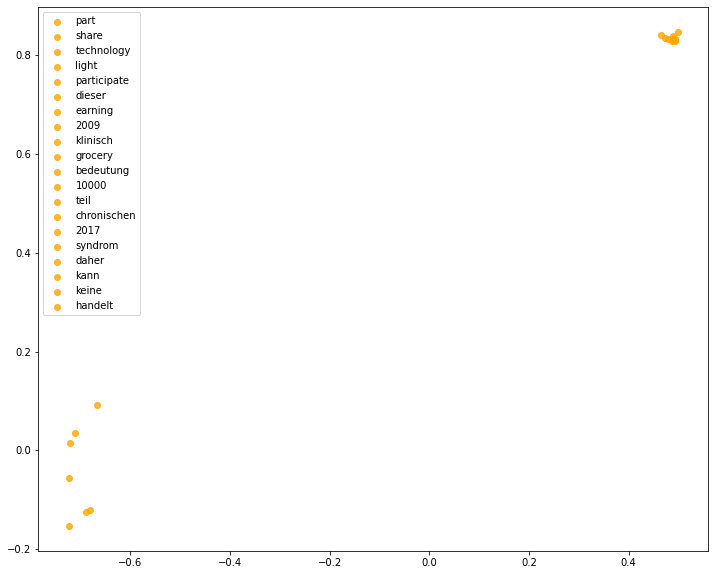

In [ ]:
plot_similar("apple", 20)

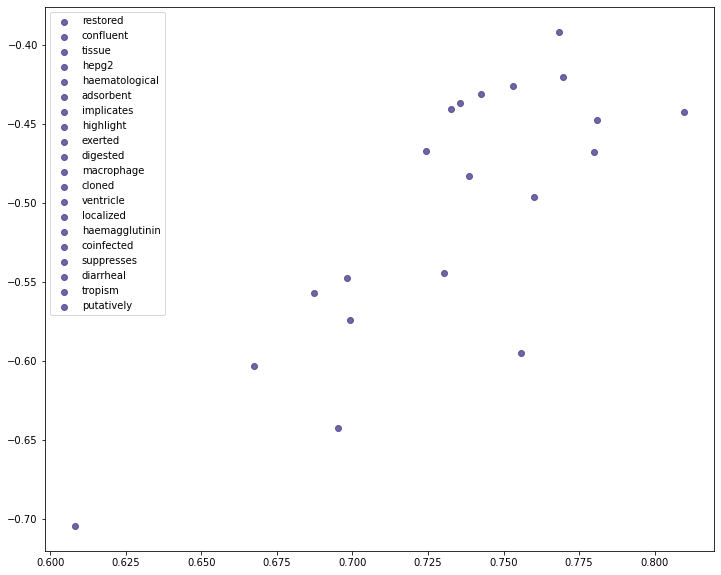

In [ ]:
plot_similar('covid', 20, 123)

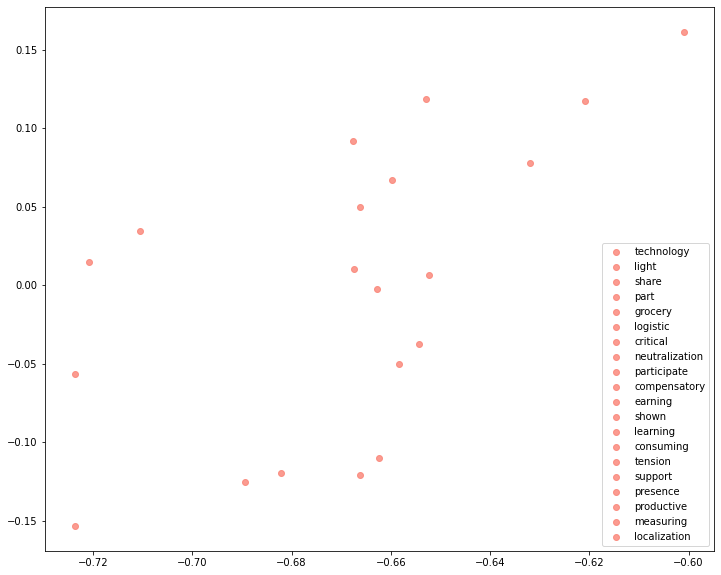

In [ ]:
plot_similar("tumour", 20, 23)

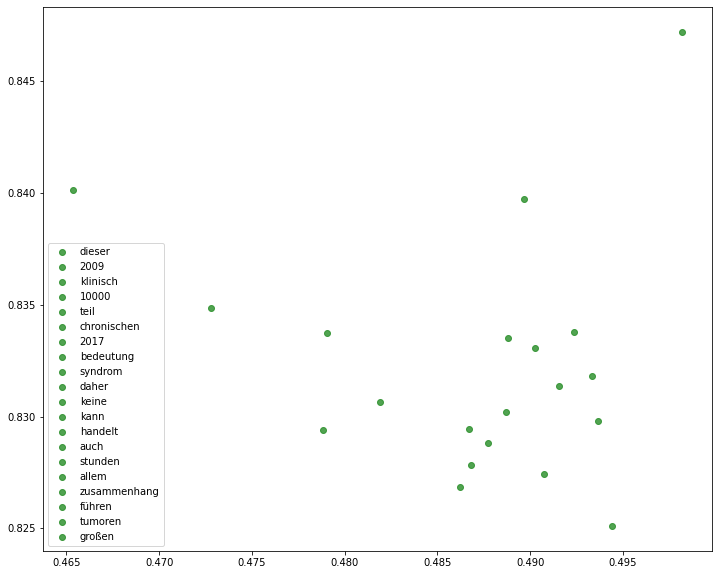

In [ ]:
plot_similar("german", 20,74)

#Table of common words

In [ ]:
def make_table(nouns, width = 5):
  word_table = {}
  for noun in nouns:
    rem1 = list(word_similarity[noun].keys())[:width]
    word_table[noun] = [ind_wrd[item] for item in rem1]
  table = pd.DataFrame(word_table)
  return table

In [ ]:
nouns = ["apple", "covid", "tumour", "german"]
make_table(nouns)

,apple,covid,tumour,german
0,part,restored,technology,dieser
1,share,confluent,light,2009
2,technology,tissue,share,klinisch
3,light,hepg2,part,10000
4,participate,haematological,grocery,teil
